# Train QAOA parameters with `qaoa_training_pipeline`

In [1]:
# uncomment and run this cell to install requirements for the notebook

# !pip install qaoa_training_pipeline@git+https://github.com/qiskit-community/qaoa_training_pipeline@fc866dcfa27443a012253580f105395def1f0dc1
# !pip install qiskit-aer
# !pip install pylatexenc

This notebook contains practical examples of how to find good QAOA parameters without executing the usual optimization loop on hardware.

<img src="images/trainer.png" width="1200">

For more in-depth tutorials, check out the qaoa-training-pipeline how-to section.

**Note**: cells marked as "SETUP" are not shown in the accompanying presentation

## 1. `EfficientDepthOne` Example

In [2]:
# SETUP: build graph and define cost operator

import networkx as nx
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator

graph = nx.random_regular_graph(d=10, n=100)
cost_op = graph_to_operator(graph, pre_factor=-0.5)
print(cost_op)

SparsePauliOp(['IIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

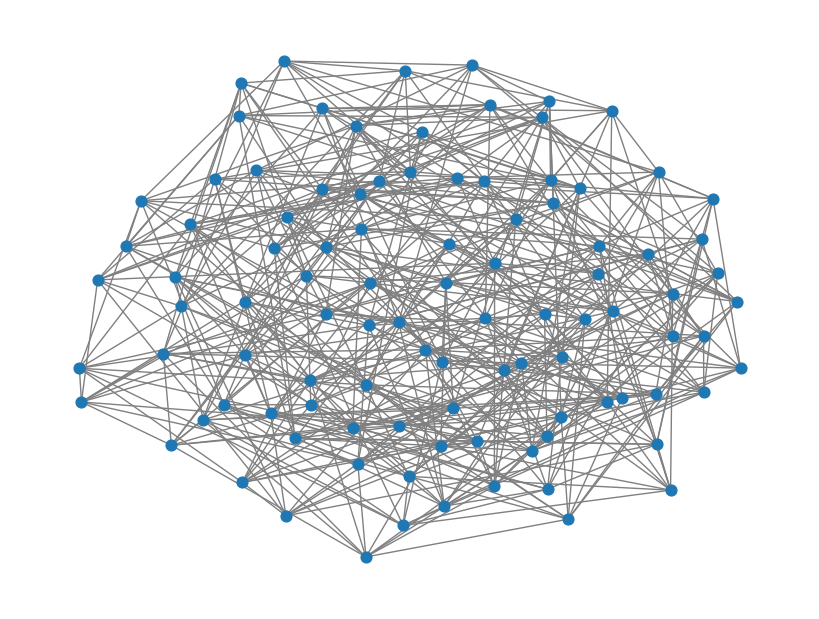

In [3]:
# SETUP: plot graph

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Increase width and height
pos = nx.spring_layout(graph, k=0.8)  # Increase k for more spread
nx.draw(graph, pos, node_size=60, edge_color="gray")


In the following cell we execute the depth-one parameter scanner. This will compute the energy over a grid of 
 and 
 and pick the maximum energy. The parameters in the returned result are ordered as 
 to match the order of QAOAAnsatz.

In [ ]:
from qaoa_training_pipeline import (
    DepthOneScanTrainer,
    EfficientDepthOneEvaluator,
)

trainer = DepthOneScanTrainer(EfficientDepthOneEvaluator())
result = trainer.train(cost_op, num_points=20)

print(result["optimized_params"])
print(result.keys())

In [ ]:
print(result["optimized_params"])

[1.1574288723751869, 5.9524913436438185]


Finally, we convert the energy to the average cut value and plot the energy landscape.

In [ ]:
# SETUP: compute avg cut and plot

import matplotlib.pyplot as plt

avg_cut = result["energy"] + len(graph.edges()) / 2
print(avg_cut)

294.9615403654009


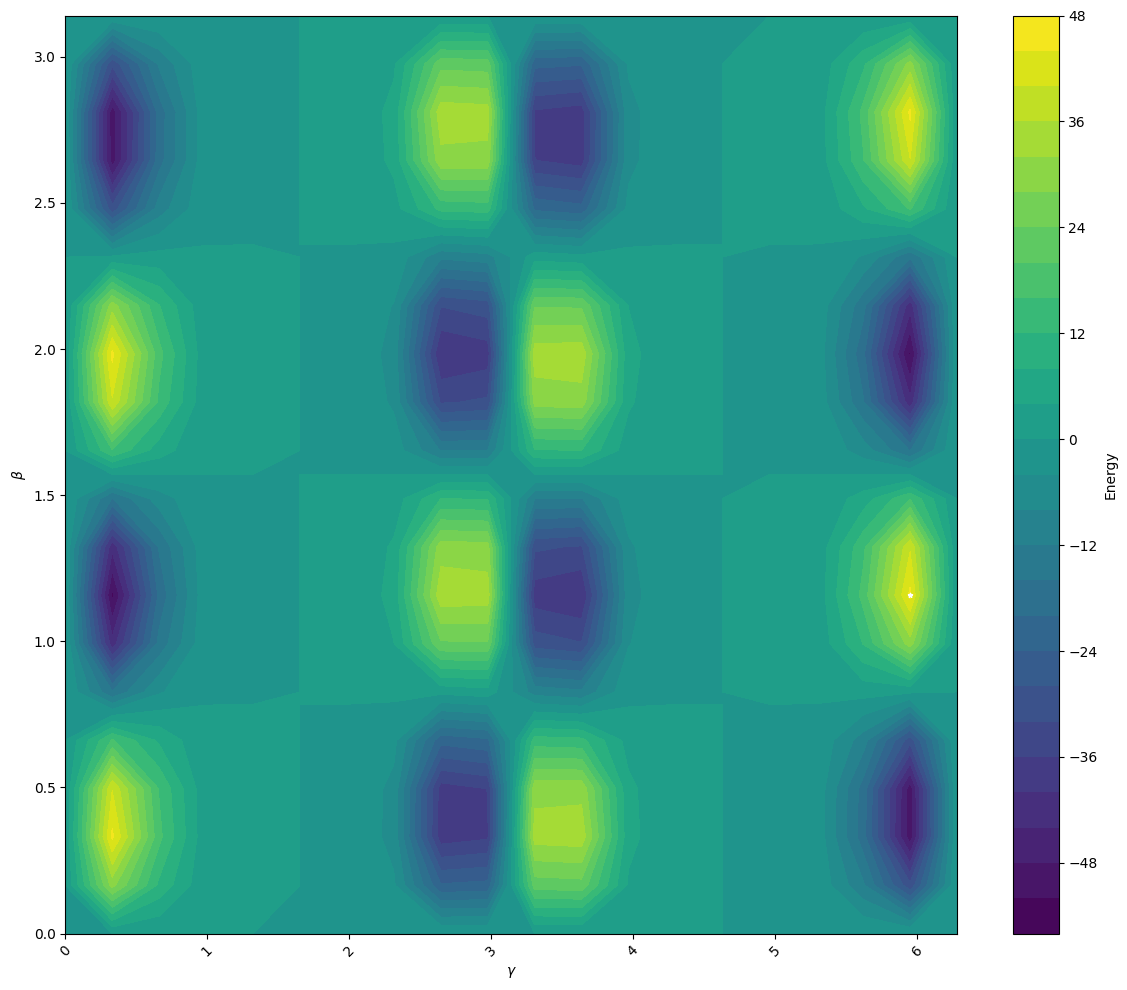

In [ ]:
# SETUP: plot

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
trainer.plot(axis=axs, fig=fig)

plt.xticks(rotation=45)
plt.tight_layout()

## 2. Angle Functions Example

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qaoa_training_pipeline.utils.graph_utils import (
    load_graph,
    graph_to_operator,
)

In [ ]:
graph = load_graph("data/example_graph.json")
cost_op = graph_to_operator(graph, pre_factor=-0.5)
cost_op

SparsePauliOp(['IIIIZZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IZIIZI', 'IZZIII', 'ZIIZII', 'ZIZIII', 'IIZZII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j])

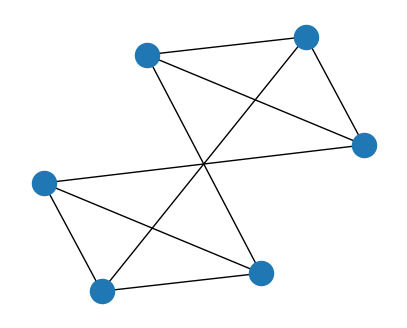

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
nx.draw_kamada_kawai(graph, ax=ax)

**Recursive optimization**

In the following we recursively optimize the coefficients of the Fourier representation of the QAOA parameters. The underlying is a depth-ten 10 as indicated by
```
FourierFunction(depth=10)
```

The recursive trainer will start from an initial point found via a depth-one scan in the Fourier basis. This will produce a good initial point 
 with which to seed the recursion. The initial points at depth 
 are trvially found from depth 
 by extending the parameter vector with zeros. This is done by the trivial_extend function. It corresponds to extending the Fourier basis by one mode, initially set to amplitude zero.


In [ ]:
from qaoa_training_pipeline.training.functions import FourierFunction
from qaoa_training_pipeline.training.parameter_extenders import (
    trivial_extend,
)
from qaoa_training_pipeline.training import *
from qaoa_training_pipeline.evaluation import *

angles_func = FourierFunction(depth=10)
pre_trainer = DepthOneScanTrainer(
    StatevectorEvaluator(), qaoa_angles_function=angles_func
)
sub_trainer = ScipyTrainer(
    StatevectorEvaluator(),
    minimize_args={"options": {"maxiter": 500, "rhobeg": 0.2}},
    qaoa_angles_function=angles_func,
)
r_trainer = RecursionTrainer(sub_trainer, trivial_extend)
p_result = pre_trainer.train(cost_op, parameter_ranges=((0, np.pi), (0, np.pi)))
r_result = r_trainer.train(cost_op, params0=p_result["optimized_params"], reps=6)
optimal_angles = r_result["optimized_qaoa_angles"]
print(optimal_angles)

[0.6164993632223377, 0.5379203609594146, 0.443556008481232, 0.3650150455764492, 0.2854327277343956, 0.20280307313330476, 0.13644143579859033, 0.08695686859163332, 0.044683150719954004, 0.012462474326784167, 0.10214512932541821, 0.2982288129115774, 0.4717431516396372, 0.6101212693879858, 0.7119674260373194, 0.805683634402824, 0.9254689476774598, 1.0563721368681207, 1.1465107170448046, 1.1795161841740567]


We also prepare an optimize QAOA circuit and sample from it to show that we indeed get good samples. The optimal QAOA angles are found in rresult["optimized_qaoa_angles"]. Below, we observe that each level of the recusion increases the energy which is a sign of a good optimization.

In [ ]:
print(len(optimal_angles) // 2)

10


In [ ]:
from qiskit import generate_preset_pass_manager
from qiskit.circuit.library import qaoa_ansatz
from qiskit_ibm_runtime import Sampler
from qiskit_aer import Aer

optimal_circuit = qaoa_ansatz(cost_op, reps=len(optimal_angles) // 2)
optimal_circuit.assign_parameters(optimal_angles, inplace=True)
optimal_circuit.measure_all()

sampler = Sampler(mode=Aer.get_backend("qasm_simulator"))
pm = generate_preset_pass_manager(basis_gates=["sx", "x", "rzz", "rz"])
isa_circuit = pm.run(optimal_circuit)
sampler_result = sampler.run([isa_circuit]).result()[0].data.meas.get_counts()

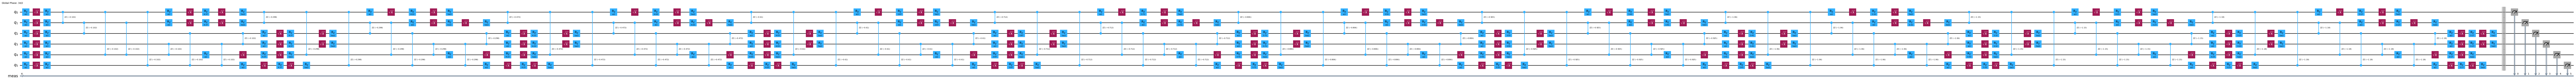

In [ ]:
isa_circuit.draw("mpl", fold=-1)

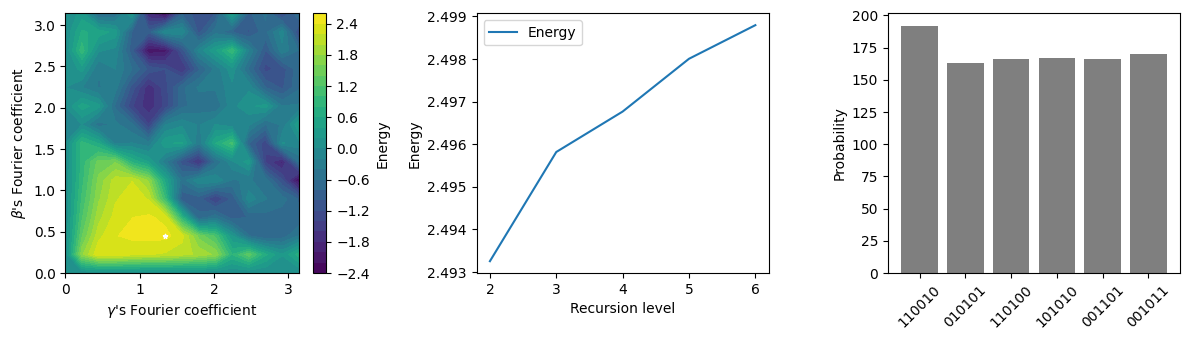

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
pre_trainer.plot(
    fig=fig,
    axis=axs[0],
    xlabel=r"$\gamma$'s Fourier coefficient",
    ylabel=r"$\beta$'s Fourier coefficient",
)
r_trainer.plot(fig=fig, axis=axs[1])
axs[2].bar(
    list(sampler_result.keys()),
    list(sampler_result.values()),
    color="tab:grey",
)
axs[2].set_ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()